<a href="https://colab.research.google.com/github/DrAlexSanz/amld2021-unsupervised/blob/master/Alex_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Solution: Demonstration of several algorithms on the Pen Digits dataset

Exercises using the Pen Digits Dataset: https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/literature/PenDigits/PenDigits_v01.html

The data consists of a .csv files, created by recording the writing pattern (x and y's) of digits on a digital writing pad. The digit "4" is downsampled to only 20 instances (instead of ~1000 for the other points), making it an outlier. 

Note that (unlike MNIST) the features are not pixel values, but are x,y subsampled coordinate pairs, for a total of 8 pairs. 

This dataset is small and simple: it has only numeric features and no NaN's.

# **This is a training dataset. Normally I wouldn't have labels.**

# Package installing and data import

In [2]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab, need to get data and install libraries..')
    data_path = './'
    # Now only load the required files...
    !curl -O https://raw.githubusercontent.com/DrAlexSanz/amld2021-unsupervised/master/notebooks/outlierutils.py
    !curl -O https://raw.githubusercontent.com/DrAlexSanz/amld2021-unsupervised/master/data/x_pendigits.csv
    !curl -O https://raw.githubusercontent.com/DrAlexSanz/amld2021-unsupervised/master/data/y_pendigits.csv
    !pip install --upgrade pyod
else:
    print('Not running on CoLab, data and libraries are already present')
    data_path = '../data'


Running on CoLab, need to get data and install libraries..
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13595  100 13595    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  761k  100  761k    0     0  2810k      0 --:--:-- --:--:-- --:--:-- 2800k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19744  100 19744    0     0   132k      0 --:--:-- --:--:-- --:--:--  132k
     |████████████████████████████████| 111 kB 5.4 MB/s 
  Created wheel for pyod: filename=pyod-0.9.4-py3-none-any.whl size=130726 sha256=bdda52d1ea732c1f61dfec4149612a62f853d83b702c76232a54c89f687af627
  Stored in directory: /ro

## Imports

In [3]:
# Library imports
import os

import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

I'm importing two helper functions, for easy plotting:
* plot_top_N:
  * Plots the actual binary labels (Positive versus Negative) of the N points
    with the highest outlier scores.
  * Takes y_true (labels), the scores and N.

* plot_outlier_scores:
  * Plots the distributions.
  * Takes the y_trues and the scores.

In [4]:
from outlierutils import plot_top_N, plot_outlier_scores # For easy plotting and evaluation

## Data loading

In [5]:
from sklearn.preprocessing import MinMaxScaler # Originally it was StandardScaler, I prefer MinMaxScaler because data shouldn't be a Normal distribution.
x_pen_raw = pd.read_csv('x_pendigits.csv')
y_pen = pd.read_csv('y_pendigits.csv')['outlier']

# Scale and put again into a DataFrame before doing anything.
sc = MinMaxScaler()
x_pen = pd.DataFrame(data=sc.fit_transform(x_pen_raw))

In [6]:
print(f'Number of points: {len(y_pen)}')
print(f'Number of positives: {y_pen.sum()} ({y_pen.mean():.3%})')

Number of points: 9868
Number of positives: 20 (0.203%)


## Show some of the data without scaling.

If I use standard scaler I will plot very strange figures

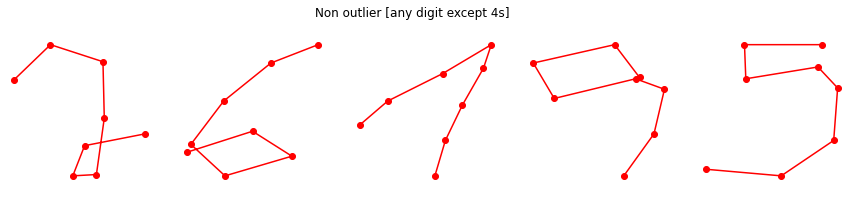

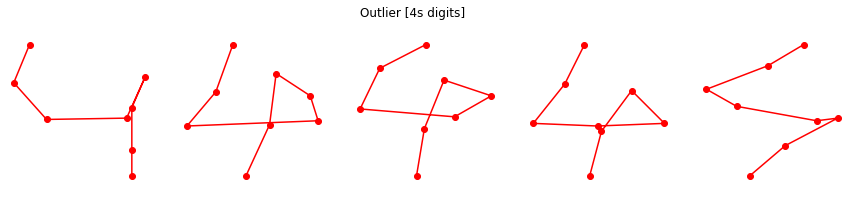

In [7]:
non_outlier = y_pen[y_pen == 0]
outlier = y_pen[y_pen == 1]  

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs = axs.ravel()
for ax, i in enumerate([15, 4, 1, 8, 1234]):
    xcoor = x_pen_raw.iloc[non_outlier.index[i], :].values.reshape([8,2])
    axs[ax].plot(xcoor[:,0], xcoor[:,1],'ro-')
    axs[ax].axis('equal')
    axs[ax].axis('off')
fig.suptitle('Non outlier [any digit except 4s]')

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs = axs.ravel()
for ax, i in enumerate(range(5)):
    xcoor = x_pen_raw.iloc[outlier.index[i], :].values.reshape([8,2])
    axs[ax].plot(xcoor[:,0], xcoor[:,1],'ro-')
    axs[ax].axis('equal')
    axs[ax].axis('off')
fig.suptitle('Outlier [4s digits]');

## Visualization with t-SNE

In [8]:
from sklearn.manifold import TSNE

N_downsample = 3000
assert x_pen.index.equals(y_pen.index), 'Error, indexes differ. Reset them to continue'
x_downsampled = pd.concat((x_pen[y_pen==0].sample(N_downsample - int(y_pen.sum()), random_state=1),
                           x_pen[y_pen==1]), 
                          axis=0).sample(frac=1, random_state=1)
y_downsampled = y_pen[x_downsampled.index]

In [9]:
MAX_N_TSNE = 3500 #Avoid overly long computation times with TSNE. Values < 5000 recommended 
neg = y_downsampled == 0
pos = y_downsampled == 1

assert len(x_downsampled) <= MAX_N_TSNE, f'Using a dataset with more than {MAX_N_TSNE} points is not recommended'
X_2D = TSNE(n_components=2, 
            perplexity=50, 
            n_iter=400,
           random_state=5).fit_transform(x_downsampled) 


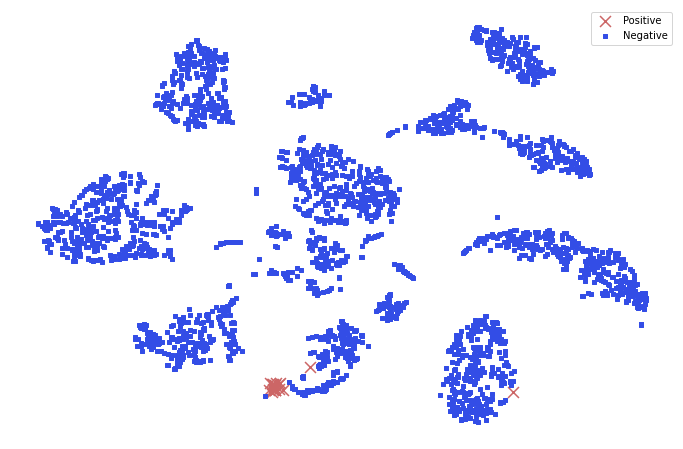

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(X_2D[pos, 0], X_2D[pos, 1], c=[[0.8, 0.4, 0.4],], marker='x', s=120, label='Positive')
ax.scatter(X_2D[neg, 0], X_2D[neg, 1], c=[[0.2, 0.3, 0.9],], marker='s', s=10, label='Negative')

plt.axis('off')
plt.legend()
plt.show() 

### Some observations:
- Depending on the perplexity, we see roughly 10 clusters, not all well-defined. This is in line with the expectation to see 9 + 1 (the 9 digits plus "4", the undersampled outlier class)
- The outlier class forms a single cluster, rather than being scattered across
- This corresponds to our understanding of the data: the outlier class is really an under-represented class

### How about PCA?

I can see a few clusters but it doesn't capture the underlying structure of the data.

In [11]:
from sklearn.decomposition import PCA

PCA_2D = PCA(n_components = 2).fit_transform(x_downsampled)

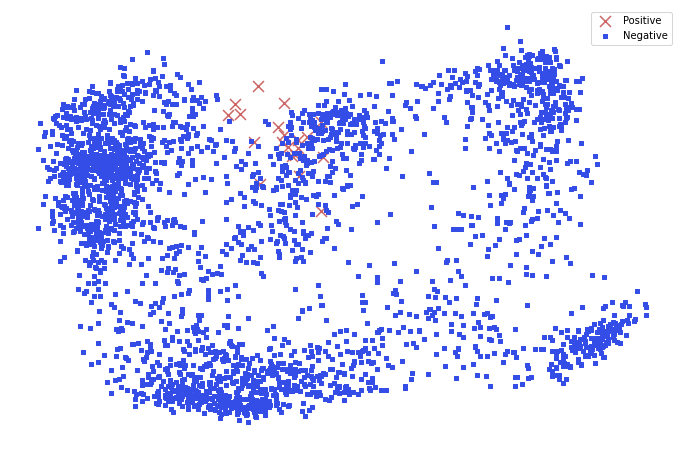

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(PCA_2D[pos, 0], PCA_2D[pos, 1], c=[[0.8, 0.4, 0.4],], marker='x', s=120, label='Positive')
ax.scatter(PCA_2D[neg, 0], PCA_2D[neg, 1], c=[[0.2, 0.3, 0.9],], marker='s', s=10, label='Negative')

plt.axis('off')
plt.legend()
plt.show() 

## Mahalanobis Distance

Generalized distance. 

For culture, we can calculate the Mahalonobis distance in two ways:
- Directly: Calculating the Covariance matrix (with the full data, or with the robust MinCovDet), then the Mahalonobis distance
- Indirectly: Do a whitened PCA decompose with full-rank, calculate the Euclidean distance

We will take the first option:

In [13]:
from sklearn.covariance import MinCovDet, EmpiricalCovariance

cov_ = EmpiricalCovariance().fit(x_pen)
#cov_ = MinCovDet().fit(x_pen) # Numerically robust estimation. Totally unnecessary and worse results.
mahalonobis_scores = cov_.mahalanobis(x_pen)
mahalonobis_scores = np.clip(mahalonobis_scores, 0, 60)

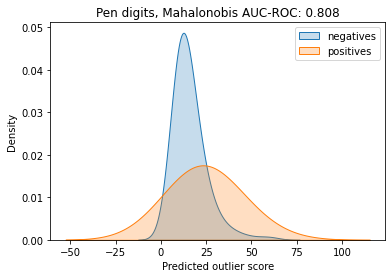

In [14]:
res = plot_outlier_scores(y_pen, mahalonobis_scores, bw_adjust=4, title='Pen digits, Mahalonobis')

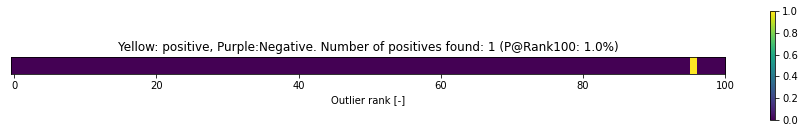

In [15]:
res = plot_top_N(y_pen.values, mahalonobis_scores) # The higher the scores the more the algorithm believes that it's an outlier

### Mahalonobis results

**AUC-ROC-score: 0.81, P@100 1%**

* I get 0.81 as AUC, not bad for a simple method.
* The positives at 100 is the number of outliers that I found in the first 100 points. I should have 20 outliers with the highest scores and 80 inliers below. I only found 1 and it's in position 90 something, so this method is easy to implement and fast to calculate but not too accurate.

## Gaussian Mixture Models

This is not a multivariate Gaussian, it's a linear combination of different Gaussian distributions, which can be multivariate themselves.

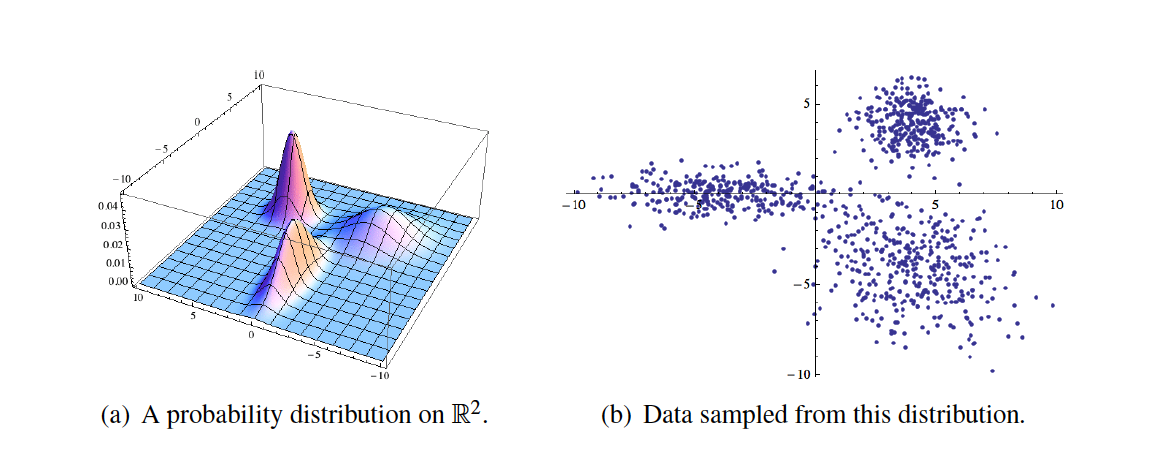

### For the parameters:

* I need to choose the number of components (distributions). 9 seems like a good starting point because I know that I have 9 digits and 4 as outliers. I can also do an elbow plot, it's not too expensive.
* In general I can't know which points came from which component.

In [16]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=9, covariance_type='full', random_state=1) # try also spherical, this is a symmetric distribution
gmm.fit(x_pen, )
gmm_scores = - gmm.score_samples(x_pen) # In this case sklearn gives the negative of the scores.

In [17]:
gmm_scores = np.clip(gmm_scores, -15, 50)

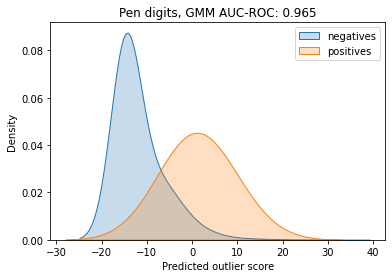

In [18]:
res = plot_outlier_scores(y_pen, gmm_scores, bw_adjust=4, title='Pen digits, GMM')

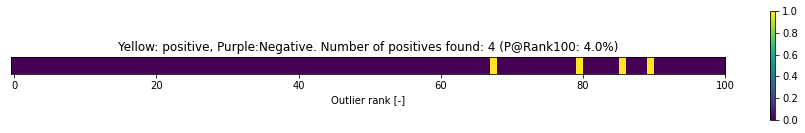

In [19]:
res = plot_top_N(y_pen.values, gmm_scores)

### The results are much better with GMM than with Mahalanobis.

* The model is more powerful.
* The AUC is much better, 96.5%, with very little thinking from my side.
* If I do a t-SNE plot, GMM and t-SNE agree in most of the clusters although the outliers are scattered and cluster 8 is all over the place.
* t-SNE and GMM are not the absolute truths, only models.

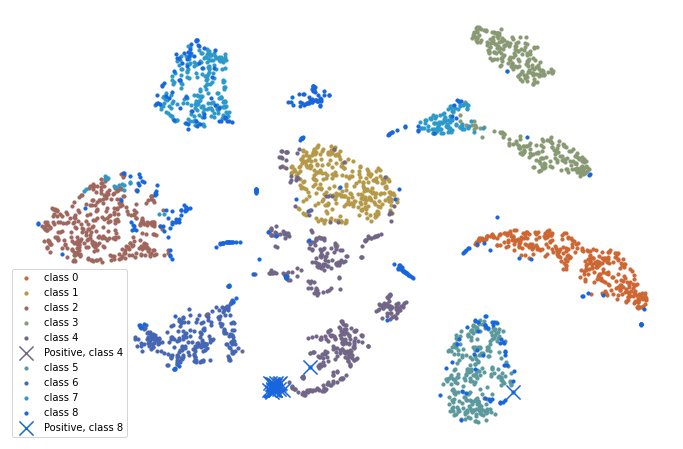

In [20]:
labels_ds = gmm.predict(x_downsampled)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

n_components = gmm.n_components
for i, class_ in enumerate(range(n_components)):
    idx = np.where(labels_ds == i)[0]
    idx_pos = np.where((labels_ds == i) & (pos.values))[0]
    
    c=[(0.8-0.8*(i/n_components), 0.4 + 0.2*(i%2), 0.2+0.75*(i/n_components)), ]
    ax.scatter(X_2D[idx, 0], X_2D[idx, 1], c=c, 
               marker='o', s=10, label=f'class {i}')
    if len(idx_pos):
        ax.scatter(X_2D[idx_pos, 0], X_2D[idx_pos, 1], c=c, 
           marker='x', s=200, label=f'Positive, class {i}')     

plt.axis('off')
plt.legend()
plt.show() 
    

###**Let's see what is the number of components that produces the best AUC.**

**This is highly dependent in my data. Today, in this problem, I may need 10 components and if the data distribution changes or I try to apply the same model to a different problem, the optimum number of components may be different.**

In [21]:
from sklearn.metrics import roc_auc_score

n_components_list = list(range(3, 20))
gmm_scores_list = [GaussianMixture(n_components=i, covariance_type='full', random_state=1).fit(x_pen).score_samples(x_pen)
 for i in n_components_list]# try also spherical, although in this case it gives worse results.
gmm_roc_scores = [roc_auc_score(y_pen, - y_pred_) for y_pred_ in gmm_scores_list]

### Clearly it's better to use 7 components in this case

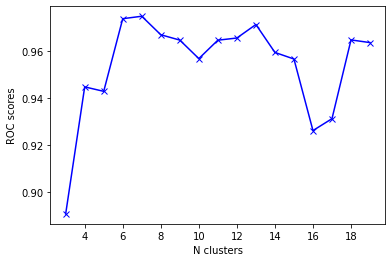

In [22]:
fig, ax = plt.subplots()
ax.plot(n_components_list, gmm_roc_scores, 'b-x', label='ROC AUC [-]')
ax.set_xlabel('N clusters')
ax.set_ylabel('ROC scores');

## **K-nearest neighbours (UNSUPERVISED!!)**

### **We normally don't have labels!!**.

The supervised algorithm is named KNeighborsClassifier and the fit requires (X,y)

Alternatively we can try KMeans from Scikit-Learn, it's an unsupervised method.

##### **Unsupervised KNN will compute the distance between points, KMeans will compute the distance to centroids.**

[Check this explanation](https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9) for more details.



#### **First:** verify that the nearest neighbours of outliers are usually outliers (as one may expect from the TSNE plot)


In [23]:
from sklearn.neighbors import NearestNeighbors

clf_nn = NearestNeighbors(n_neighbors=21) # NB: the first neighbour is the point itself
clf_nn.fit(x_pen)
Nth_neighbour = 20
distances, indices = clf_nn.kneighbors(x_pen)
nearest_ns = indices[:, Nth_neighbour]

print(f'Fraction of {Nth_neighbour}th neighbor that is an outlier, conditional on y==1: {y_pen[nearest_ns[y_pen==1]].mean():.2%}')      
print(f'Fraction of {Nth_neighbour}th neighbor that is an outlier, conditional on y==0: {y_pen[nearest_ns[y_pen==0]].mean():.2%}')

Fraction of 20th neighbor that is an outlier, conditional on y==1: 0.00%
Fraction of 20th neighbor that is an outlier, conditional on y==0: 0.04%


The first neighbour of an outlier is an outlier in 90% of the cases. Even the 10th neigbour is an outlier in more than 50 %. Indeed, as observed in t-SNE, outliers are close together in this case. 


### A 2.2 Use pyod to get outlier scores (distances)

The advantage of the PyOD implementation vs. Scikit-Learn is that the API is consistent with the other algorithms (fit(), labels_...).

In Scikit-Learn when you instantiate the KNN object you can set the return_distance = True in the kneighbors method and it's equivalent to the implementation below.

### Important notice

Either I set a threshold score to define an outlier or the algorithm does it for me by assigning outlier labels to N points, with $N = n_{samples} \cdot contamination$.

Anyway I set the contamination myself to 0.1% for example, another option is to set it to whatever, plot the scores and decide a threshold.

In [70]:
from pyod.models.knn import KNN

# train kNN detector
n_neighbours = 31

clf = KNN(method='largest', n_neighbors=n_neighbours)
clf.fit(x_pen)
# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_
knn_labels =  clf.labels_ # binary labels (0: inliers, 1: outliers)
knn_scores = clf.decision_scores_  # raw outlier scores

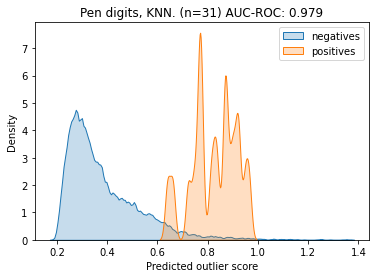

In [25]:
res = plot_outlier_scores(y_pen, knn_scores, bw_adjust=0.2, 
                          title=f'Pen digits, KNN. (n={n_neighbours})')

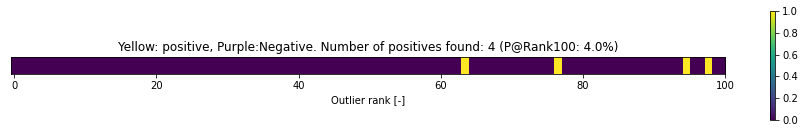

In [26]:
res = plot_top_N(y_pen.values, knn_scores)

### KNN results

* With 31 neighbours we get AUC = 0.98, which is the best so far.
* The distributions of positive and negatives are very separated in this case, the peaks and valleys of the positive are so pronounced because the number of neighbours is high. With 5 neighbours it will be smooth and with a lot of false negatives, with a high number it will be very spiky and full of false positives.
* It's great to see that a "simple" classifier produces a very good result. However, this is a bit 

### Comparing scores for a range of n_neighbors

Let's do a similar elbow plot again to see how many neighbours I should use and to see how that number compares to my estimation of around 20 neighbors.

In [27]:
from sklearn.metrics import roc_auc_score

def calc_precision_at_100(scores):
    return y_pen[np.argsort(scores)][::-1][:100].mean()

    
n_neighbour_list = [1+i*5 for i in range(20)]
knn_scores_list = [KNN(method='median', n_neighbors=n).fit(x_pen).decision_scores_
                  for n in n_neighbour_list]

knn_roc_auc_scores = [roc_auc_score(y_pen, knn_score) for knn_score in knn_scores_list]
knn_precision_at_100 = [calc_precision_at_100(knn_score) for knn_score in knn_scores_list]


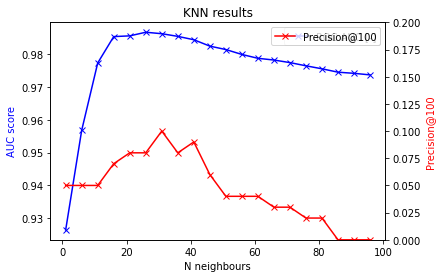

In [28]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(n_neighbour_list, knn_roc_auc_scores, 'b-x', label='ROC AUC [-]')
ax2.plot(n_neighbour_list, knn_precision_at_100, 'r-x', label='Precision@100')
ax.set_xlabel('N neighbours');
ax.set_ylabel('AUC score', color='b');
ax2.set_ylabel('Precision@100', color='r');
ax2.set_ylim([0, 0.2])
ax.legend()
ax2.legend()
ax.set_title('KNN results');

### Optimal k is about 30-31 (both AUC-ROC and p@100). 

* Precision@100 is much stronger affected by n_neighbours than the AUC-ROC score.

* Choosing `n_neighbours` too high leads to a dilution of the scores and a strong decrease in the top-100 precision.

## 3. Local Outlier Factor (LOF)

### Idea

**Outliers are difficult to reach if you try to get there from another point. If you are part of a cluster, your density (reachability) is similar to the neighbours. If you are an outlier, the density will change, even if you are close to a cluster. It can detect P1 and P2 below, as well as P3.** All the algorithms would detect P3, but may would struggle with P1 and P2 below.

LOF compares the "reachability-density" of an object to the average density of its neighbours. It's the inverse of the reachability distance. If the object is close (distance small) reachability is high, and vice-versa.

Points that are part of one cluster all have a similar density, and thus get a score of around 1. An isolated point has a much lower density than its nearest neighbour (P1, P2 and P3) when that neighbour is part of a dense cluster, and gets a high outlier score. 

###**From Sklearn documentation.**

The number of neighbors considered (parameter n_neighbors) is typically set
1. greater than the minimum number of samples a cluster has to contain, so that other samples can be local outliers relative to this cluster.
2. smaller than the maximum number of close by samples that can potentially be local outliers. In practice, such information is generally not available, and taking n_neighbors=20 appears to work well in general.


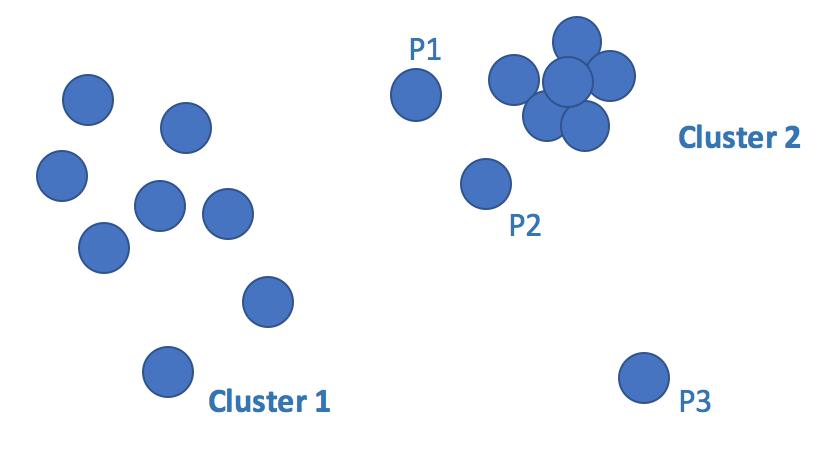

**Example 1:** N_neighbours = 10

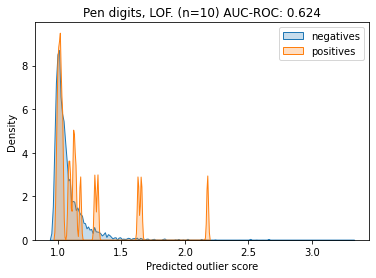

In [29]:
from pyod.models.lof import LOF

n_neighbours = 10
lof = LOF(n_neighbors=n_neighbours, contamination=0.01)
lof.fit(x_pen)
lof_scores = lof.decision_scores_
res = plot_outlier_scores(y_pen, lof_scores, 
                          bw_adjust=0.04, title=f'Pen digits, LOF. (n={n_neighbours})')

**Example 2:** N_neighbours = 50

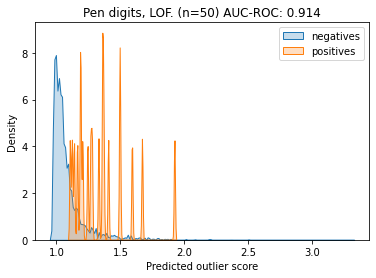

In [30]:
n_neighbours = 50
lof = LOF(n_neighbors=n_neighbours, contamination=0.01)
lof.fit(x_pen)
lof_scores = lof.decision_scores_

res = plot_outlier_scores(y_pen, lof_scores, 
                          bw_adjust=0.04, title=f'Pen digits, LOF. (n={n_neighbours})')

`n_neighbours` of about 50 seems suitable. Clearly, it needs to be larger than the number of outliers (in the original data), since these form a single cluster. 


### Compare scores for a range of n_neighbors

In [31]:
# Loop over a range of n_neighbours
n_neighbour_list = [1+i*5 for i in range(20)]
lof_scores_list = [LOF(n_neighbors=n).fit(x_pen).decision_scores_
                  for n in n_neighbour_list]

In [32]:
lof_roc_auc_scores = [roc_auc_score(y_pen, score) for score in lof_scores_list]

N_ = 100
lof_precision_at_N = [y_pen[np.argsort(score)][::-1][:N_].mean() for score in lof_scores_list]


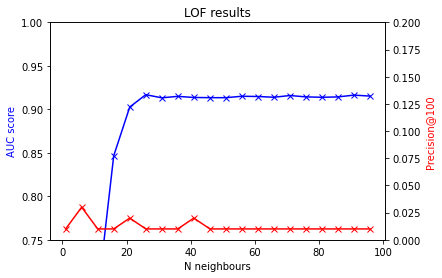

In [33]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(n_neighbour_list, lof_roc_auc_scores, 'b-x', label='ROC AUC [-]')
ax2.plot(n_neighbour_list, lof_precision_at_N, 'r-x', label=f'Precision@{N_}')
ax.set_xlabel('N neighbours');
ax.set_ylim([0.75, 1])
ax.set_ylabel('AUC score', color='b');
ax2.set_ylabel(f'Precision@{N_}', color='r');
ax2.set_ylim([0, 0.2])

ax.set_title('LOF results');

### LOF results

Note that LOF requires indeed a large n_neighbours to spot the outliers (for the AUC metric), whereas this dilutes the results, giving a worse precision@100. 

* LOF is clearly less suited to this particular dataset. If this was in production perhaps it would be a good idea to keep it inside the ensemble with a lower weight. In case of data distribution drift it could be useful to have it or not. Maybe we can have it as a benchmark instead or decide not to use it at all, that's also an answer.

* With k=10, LOF has a ROC score of 0.59, which is hardly better than random guessing. 

* With k=50 ROC is 0.93. P@100 is optimal at low k (max 2%), whereas ROC requires k=50 or larger.

* 31 would be a good number of neighbours but the ROC is still lower than the rest of the algorithms.


## Isolation Forest


### Limitation

Isolation Forest makes splits perpendicular to one of the dimensions. This means it is not rotationally invariant, and it will generate artifacts (points being easier to split in one of the axis directions).

As an example in 2D, there will be no issues if the dataset is distributed more or less as a circle but it can give trouble if the data follows some kind of rectangular distribution. This can be extended to N dimensions.

Running with n_estimators=1000 and 1024 samples generally produces good results. 

In [34]:
from pyod.models.iforest import IForest

ifo = IForest(n_estimators=1000, max_samples=1024, random_state=1, contamination=0.01, behaviour='new')
ifo.fit(x_pen)
# NB: in contradiction to the documentation, there is no .decision_scores_ attribute for iForest
iforest_scores = ifo.decision_scores_ #ifo.decision_function(x_pen) 

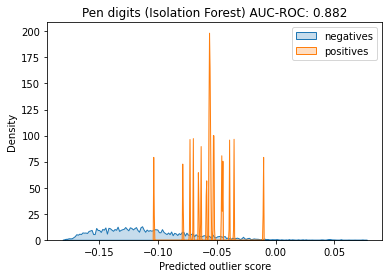

In [35]:
res = plot_outlier_scores(y_pen, iforest_scores, bw_adjust=0.02, title='Pen digits (Isolation Forest)')

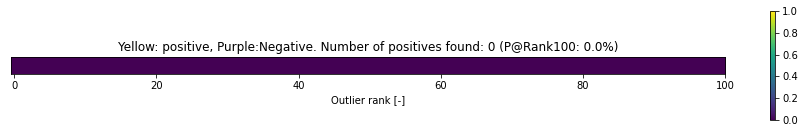

In [36]:
res = plot_top_N(y_pen.values, iforest_scores, N=100)

#### Results isolation Forest

AUC-ROC score 0.88, P@rank100 is 0

#### Running several isoForest's and comparing scores

In this case the hyperparameter that I´m tuning is the number of trees. Lower will be faster but if I run the model 10 different times I will see a big variance in the results.

In [37]:
from sklearn.ensemble import IsolationForest

n_estimators=100
ifo_clfs = [IsolationForest(n_estimators=n_estimators, max_samples=512, 
                            random_state=i, contamination=0.01)
            .fit(x_pen) for i in range(10)]
ifo_roc_scores = [roc_auc_score(y_pen.values, -ifo_clf.decision_function(x_pen)) for ifo_clf in ifo_clfs]

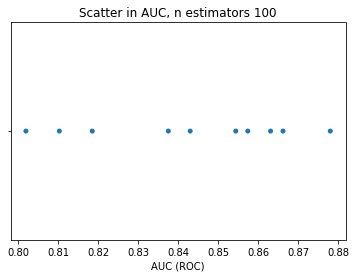

In [38]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('AUC (ROC)')
sns.swarmplot(x = ifo_roc_scores, ax=ax);
ax.set_title(f'Scatter in AUC, n estimators {n_estimators}');


### **AUC scores:**

**With 100 trees:** between 0.80 and 0.88 --> 0.88 is the highest but it may be because of random luck.

**With 1000 trees:** between 0.83 and 0.86 --> The spread is much smaller, I can probably reduce it more and even increase the AUC if I tune all the hyperparameters. The cost for this is 10 times more computing but then I know that I wasn't particularly lucky, the algorithm performs like that.

## 5. PCA reconstruction error

The main idea is that by keeping the most significant features, when I reconstruct the data, the outliers will be poorly reconstructed because they are signficantly different along the main dimensions.

### How do I know how many features I need to keep?

This is actually not an easy question at all. A common approach is to look at the explained variance ratio, but there is no golden rule for a cut-off. This is a parameter that can not be intuitively chosen (unlike the k in kNN). 


In [39]:
from sklearn.decomposition import PCA
from pyod.models.pca import PCA as pyod_PCA

# NBA: the pyod PCA is implemented differently, and does not seem to work as intended 
# pca = pyod_PCA(n_components=5, weighted=False, n_selected_components=5, standardization=True).fit(x_pen)
# pca.fit(x_pen)
# pca_scores = pca.decision_scores_

### Transform and find the average reconstruction error

$$Error = 1 - \Sigma Var_{explained}$$

So in the plot below, using 1 component means that the variance explained is 30%.

It's not clear how many components we want with this plot. Let's look at the AUC.

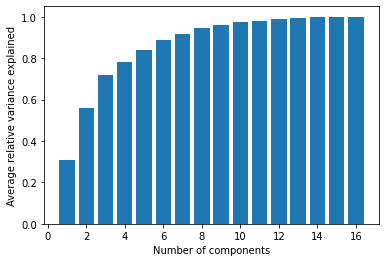

In [40]:
pca = PCA(n_components=16, whiten=False)
pca_tf = pca.fit_transform(x_pen)
plt.bar(x=range(1, 17), height = pca.explained_variance_ratio_.cumsum());
plt.ylabel('Average relative variance explained');
plt.xlabel('Number of components');

## Reconstruction

First do a transform and then use the inverse transform to get the scores. The scores are the MSE.

At this point, between 8 and 10 seem to be a good choice for the number of components.

When n_components = n_features the error should be 0.



In [41]:
pca = PCA(n_components=8, whiten=False)
pca_tf = pca.fit_transform(x_pen)
x_pen_recon = pca.inverse_transform(pca_tf)
pca_scores = ((x_pen - x_pen_recon)**2).mean(axis=1).values
#pca_scores = np.clip(pca_scores, 0, 200) # clip for plotting purposes

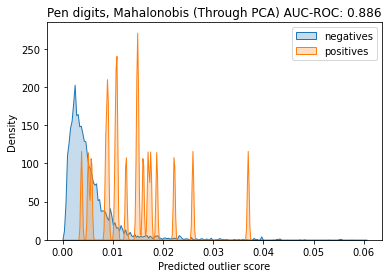

In [42]:
res = plot_outlier_scores(y_pen, pca_scores, bw_adjust=0.04, title='Pen digits, Mahalonobis (Through PCA)')

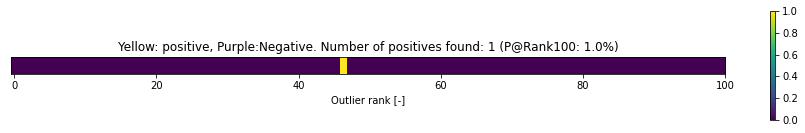

In [43]:
res = plot_top_N(y_pen.values, pca_scores, N=100)

## With an elbow plot I can see what is the optimum number of components.

9 seems to be the best choice when looking at AUC.



In [44]:
n_components_list = []
recon_error_list = []
auc_list = []
for i, n_components in enumerate(range(1, 15)):
    pca = PCA(n_components=n_components, whiten=False)
    pca_tf = pca.fit_transform(x_pen)
    x_pen_recon = pca.inverse_transform(pca_tf)
    pca_scores_ = ((x_pen - x_pen_recon)**2).mean(axis=1).values
    recon_error_list.append(1 - pca.explained_variance_ratio_[-1])
    n_components_list.append(n_components)
    auc_list.append(roc_auc_score(y_pen, pca_scores_))
 

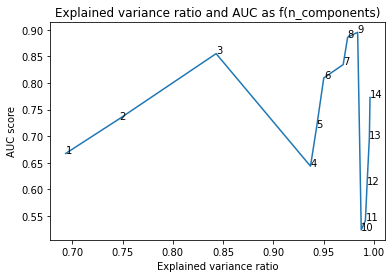

In [45]:
plt.plot(recon_error_list, auc_list)
for x, y, text in zip(recon_error_list, auc_list, n_components_list):
    plt.text(x, y, text)
plt.xlabel('Explained variance ratio')
plt.ylabel('AUC score');
plt.title('Explained variance ratio and AUC as f(n_components)');

## Autoencoder

### The same reconstruction idea can be applied to an autoencoder. Then use the encoder part to predict.

It's going to be an expensive model in terms of computation and training, **and I need labels for it. However, the labels are the inputs!**

In [46]:
from pyod.models.auto_encoder import AutoEncoder

clf = AutoEncoder(
    hidden_neurons=[10, 8, 10], # 8 seems like a good choice of hidden layer
    hidden_activation='elu',
    output_activation='linear',
    optimizer='adam',
    epochs=15,
    batch_size=16,
    dropout_rate=0.0,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=True, #NB: If TRUE, uses sklearn's StandardScaler. I don't apply normalization here.
    verbose=1,
    random_state=13,
    contamination=0.01,
)

In [47]:
clf.fit(x_pen) #Train


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 8

AutoEncoder(batch_size=16, contamination=0.01, dropout_rate=0.0, epochs=15,
      hidden_activation='elu', hidden_neurons=[10, 8, 10],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7f67f5117e60>,
      optimizer='adam', output_activation='linear', preprocessing=True,
      random_state=13, validation_size=0.1, verbose=1)

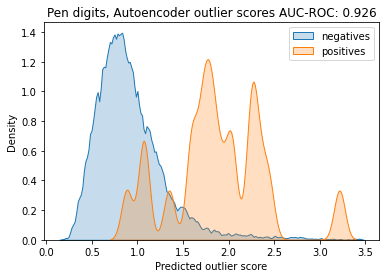

In [48]:
autoenc_scores = clf.decision_scores_  # raw outlier scores
res = plot_outlier_scores(y_pen, autoenc_scores, bw_adjust=0.2, title='Pen digits, Autoencoder outlier scores')

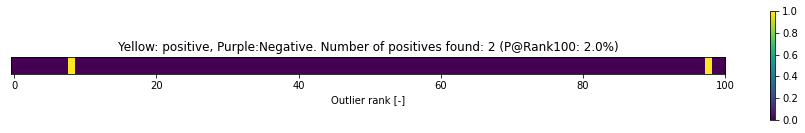

In [49]:
res = plot_top_N(y_pen.values, autoenc_scores)

**Check the reconstruction error visually**

The inliers tend to be more closely reconstructed but that is a bit subjective.

In [50]:
positive_idx = list(y_pen[y_pen==1].index)[:3]
negative_idx = list(y_pen[y_pen==0].index)[:3]

In [51]:
# Compare the original with the reconstruction to get a feeling (in StandardScaled space)
def show_reconstruction(clf, data, index, ax, title=''):
    if isinstance(data, pd.DataFrame):
        data = data.values
    data_recon = clf.model_.predict(data[[index], :])
    ax.plot(data[index, :], label='original')
    ax.plot(data_recon[0, :], label='reconstructed', linestyle='--');
    ax.legend()
    ax.set_title(title);

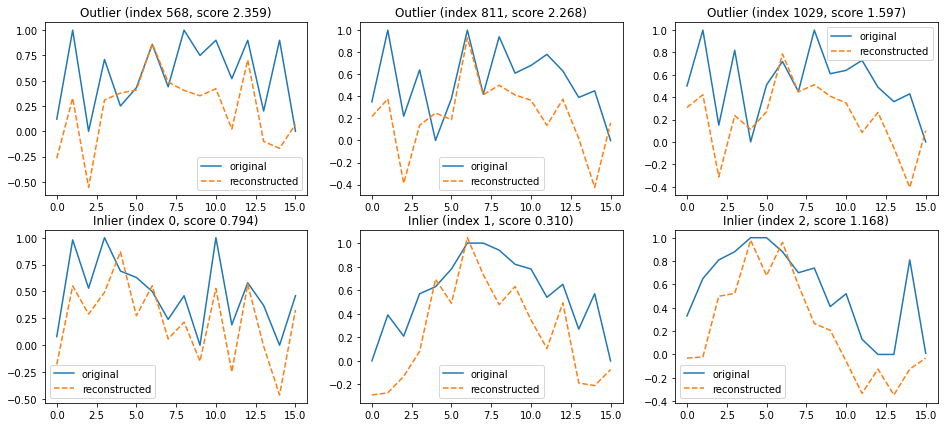

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(16, 7))
titles = ['Outlier', 'Inlier']
for i, idxs in enumerate([positive_idx, negative_idx]):
    for j, idx in enumerate(idxs):
        score = '{:.3f}'.format(autoenc_scores[idx])
        show_reconstruction(clf, x_pen, index=idx, ax=axs[i, j], title=titles[i]  + f' (index {idx}, score {score})'
                            )

#### Autoencoder results 



1.   It is possible to have a good performance with the autoencoder.
2.   There are a lot of hyperparameters to tune. Either we know something about the data that can be applied to the model creating directly or we spend time and computing resources on exploring.
3.   Consider that periodic retraining can be required.



## Make a matrix with all the results for comparison


In [53]:
scores_dict = {'mahalanobis':mahalonobis_scores,
                'knn':knn_scores,
               'lof':lof_scores,
               'gmm':gmm_scores,
               'iforest':iforest_scores,
               'pca':pca_scores,
               'autoenc':autoenc_scores}

results_dict= {'auc-roc':{alg:roc_auc_score(y_pen, score) for alg, score in scores_dict.items()},}
results_df = pd.DataFrame(results_dict).sort_values(by='auc-roc', ascending=False)

In [54]:
results_df.round(2)

,auc-roc
knn,0.98
gmm,0.96
autoenc,0.93
lof,0.91
pca,0.89
iforest,0.88
mahalanobis,0.81


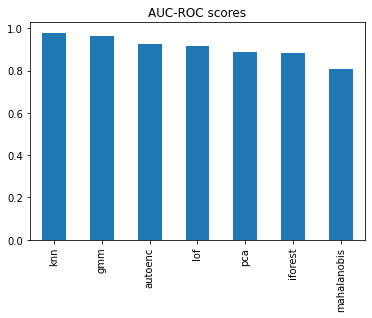

In [55]:
results_df.loc[:, 'auc-roc'].plot(kind='bar')
plt.title('AUC-ROC scores');

## Concluding remarks

For this dataset the best algorithms are KNN and the GMM. 
Both these algorithms require a single parameter, which may be possible to estimate (number of neighbours, number of clusters). In both cases, the algorithms are pretty robust with respect to the exact parameter value.

However, the best approach may be in ensembling perhaps the top 3 algorithms or KNN, GMM and LOF. A careful analysis of each algorithm individually can bring valuable information.

## Finally, the PR curve for KNN

Very tricky to interpret this in outliers detection. Ideally in balanced binary classification, the PR curve would go from (0, 1) to (1, 0) passing closer by (1, 1).

1.   Lower precision means lower false positives, which is what I want.
2.   Higher recall means that I identify all the positives.

I want it lower on the right hand side.



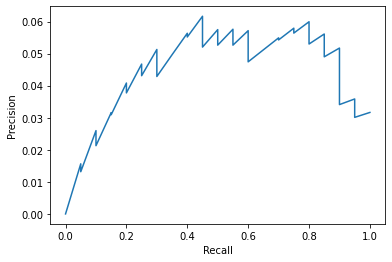

In [77]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_pen, knn_scores)
plt.plot(recall[:-1], precision[:-1]);
plt.xlabel('Recall');
plt.ylabel('Precision');

## Let's see how the algorithms compare.

The pair plot will tell me, for a point that was scored at 0.3 by KNN, it was scored at 0.35 by GMM for example. For two identical classifiers I should see a line and for similar classifiers I should see very close points.

**One option to label outliers for a NN approach (not autoencoder) is to find the outliers in the pairplot for a given pair of classifiers**.

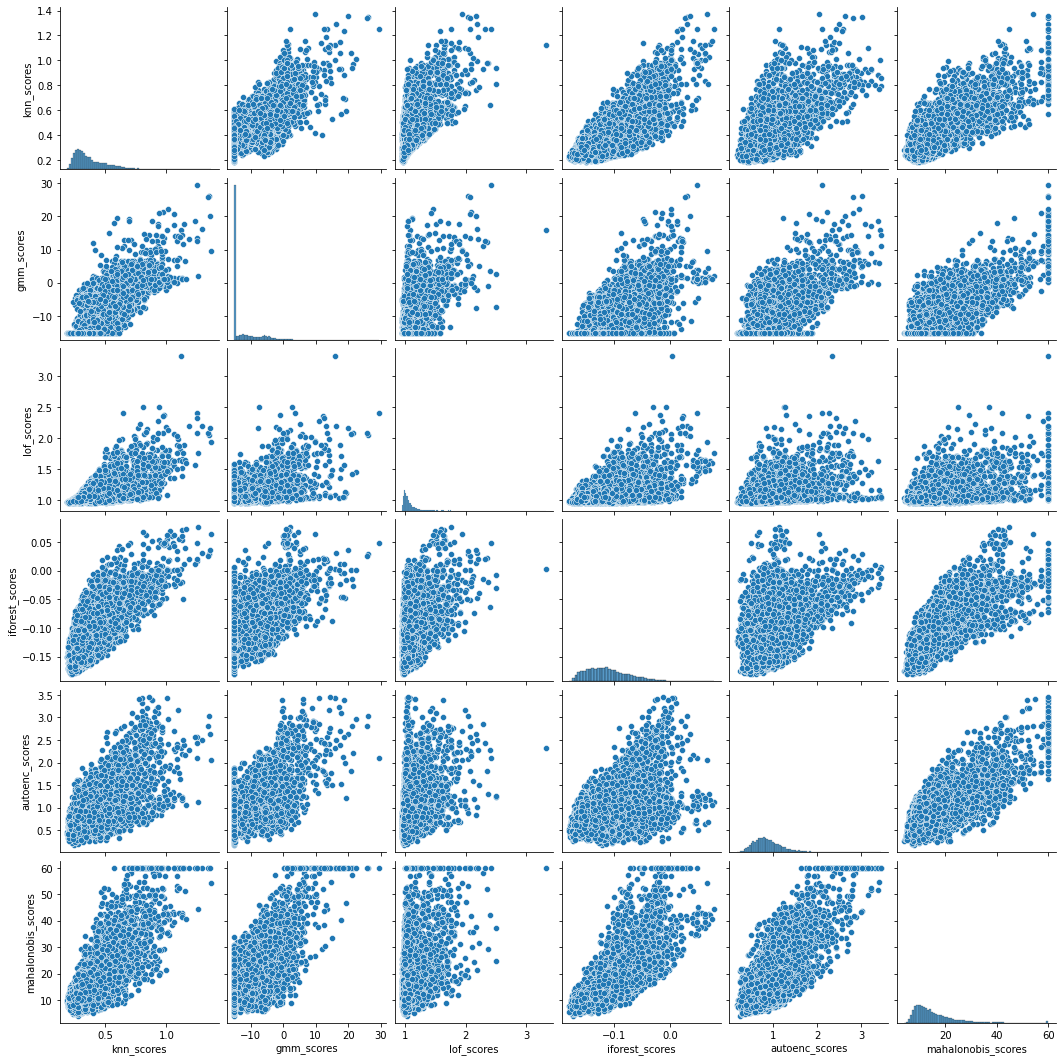

In [91]:
scores_df = pd.DataFrame()
scores_df['knn_scores'] = knn_scores
scores_df['gmm_scores'] = gmm_scores
scores_df['lof_scores'] = lof_scores
scores_df['iforest_scores'] = iforest_scores
scores_df['autoenc_scores'] = autoenc_scores
scores_df['mahalonobis_scores'] = mahalonobis_scores

sns.pairplot(scores_df);
